In [1]:
# !pip uninstall torch torchaudio torchvision -y

In [2]:
# !pip install torch==2.2.2 torchaudio==2.2.2

In [1]:
!pip install torch torchaudio torchvision datasets -q

In [2]:
import random
import IPython
import warnings
warnings.filterwarnings("ignore")

import datasets

from datasets.utils import DownloadManager

import numpy as np
from sklearn.metrics import precision_score, recall_score, balanced_accuracy_score, roc_curve, auc

import torch
import torchaudio
import torchaudio.transforms as T

from torch.utils.data import DataLoader, Dataset

import os
import sys

from tqdm import tqdm
import torchvision
import soundfile as sf
import torch.nn as nn
import torchvision.models as models
from librosa import util
import librosa.feature

import matplotlib.pyplot as plt
import math

In [3]:
sys.path.append('src')

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Load Dataset .zip from link

Logical access (LA):

- ```speaker_id:``` LA_****, a 4-digit speaker ID
- ```audio_file_name:``` name of the audio file
- ```audio:``` '****.flac'  the path to the downloaded audio file in FLAC format (https://xiph.org/flac/).
- ```system_id:``` ID of the speech spoofing system (A01 - A19), or, for bonafide speech SYSTEM-ID is left blank ('-')
- ```key:``` 'bonafide' for genuine speech, or, 'spoof' for spoofing speech

## ASVspoof2019

In [5]:
# For kaggle
import sys
sys.path.append('/kaggle/input/modules-speech-det-26-05')


In [6]:
%%time
from load_avsspoof19 import ASVspoof2019

dl_manager = DownloadManager()

speech_dataset = ASVspoof2019()
asv_datasets = speech_dataset._split_generators(dl_manager)

Computing checksums: 100%|##########| 1/1 [00:20<00:00, 20.40s/it]

CPU times: user 3min 48s, sys: 48.6 s, total: 4min 36s
Wall time: 20min 18s


In [7]:
# 0 - train, 1 - eval, 2 - test in asv_datasets
train_metadata_filepath = asv_datasets[0].gen_kwargs["metadata_filepath"]
train_audios_dir = asv_datasets[0].gen_kwargs["audios_dir"]

val_metadata_filepath = asv_datasets[1].gen_kwargs["metadata_filepath"]
val_audios_dir = asv_datasets[1].gen_kwargs["audios_dir"]

test_metadata_filepath = asv_datasets[2].gen_kwargs["metadata_filepath"]
test_audios_dir = asv_datasets[2].gen_kwargs["audios_dir"]

In [8]:
train_samples = speech_dataset._generate_examples(train_metadata_filepath, train_audios_dir)
val_samples = speech_dataset._generate_examples(val_metadata_filepath, val_audios_dir)
test_samples = speech_dataset._generate_examples(test_metadata_filepath, test_audios_dir)

## ASVspoof2021

In [ ]:
%%time
from load_avsspoof21 import ASVspoof2021

dl_manager = DownloadManager(data_dir="data")

speech_dataset = ASVspoof2021()
asv_datasets_2021 = speech_dataset._split_generators(dl_manager)

In [18]:
test_samples_21 = speech_dataset._generate_examples(
    asv_datasets[0].gen_kwargs["metadata_filepath"],
    asv_datasets[0].gen_kwargs["audios_dir"]
)

IndexError: list index out of range

## Listen to random sample

Display some audio from train/validation set.

In [9]:
def get_sample(samples):
    return random.sample(samples, k=1)[0]

sample = get_sample(train_samples)
sample

{'speaker_id': 'LA_0084',
 'audio_file_name': 'LA_T_2571489',
 'system_id': 'A04',
 'key': 'spoof',
 'audio': '/root/.cache/huggingface/datasets/downloads/extracted/911103f86670b6f7e96211444d0f39fc5ffab511156a395f67b098c2f45dce18/LA/ASVspoof2019_LA_train/flac/LA_T_2571489.flac'}

In [10]:
print(sample['key'])
IPython.display.Audio(sample['audio'])

spoof


In [11]:
sample = get_sample(val_samples)
sample

{'speaker_id': 'LA_0078',
 'audio_file_name': 'LA_D_7612955',
 'system_id': 'A01',
 'key': 'spoof',
 'audio': '/root/.cache/huggingface/datasets/downloads/extracted/911103f86670b6f7e96211444d0f39fc5ffab511156a395f67b098c2f45dce18/LA/ASVspoof2019_LA_dev/flac/LA_D_7612955.flac'}

In [12]:
print(sample['key'])
IPython.display.Audio(sample['audio'])

spoof


## Audio preprocessing


In [17]:
def audio_preprocess(waveform, sample_rate, resample_rate, desired_duration):
    resampler = T.Resample(sample_rate, resample_rate)
    resampled_waveform = resampler(waveform)
    desired_length = int(desired_duration * resample_rate)
    if len(resampled_waveform) < desired_length:
        resampled_waveform = resampled_waveform.tile(((desired_length // resampled_waveform.shape[1]) + 1,))
    resampled_waveform = resampled_waveform[:,0: desired_length]
    return resampled_waveform

def peak_normalize(waveform):
    waveform /= torch.max(torch.abs(waveform))
    return waveform

In [18]:
class AudioDataset(Dataset):
    def __init__(self, raw_dataset, desired_duration, resample_rate, transform=None):
        self.raw_data = raw_dataset
        self.transform = transform
        self.sample_rate = resample_rate
        self.duration = desired_duration

    def __len__(self):
        return len(self.raw_data)

    def __getitem__(self, idx):
        waveform, sample_rate = torchaudio.load(self.raw_data[idx]['audio'])
        if self.transform:
            waveform = self.transform[0](waveform, sample_rate, self.sample_rate, self.duration)
            waveform = self.transform[1](waveform)

        label = 1 if self.raw_data[idx]['key'] == 'spoof' else 0
        return waveform, label

In [19]:
print('hi')

hi


## ASVspoof19

In [20]:
# Define data augmentation
def augment_audio(waveform, sample_rate):
    augmentations = nn.Sequential(
        T.Vol(0.5),  # Adjust volume
        T.TimeStretch(),  # Time stretching
        T.FrequencyMasking(freq_mask_param=15),  # Frequency masking
        T.TimeMasking(time_mask_param=35)  # Time masking
    )
    return augmentations(waveform)

In [21]:
# Define AudioDataset class with data augmentation option
class AudioDataset(Dataset):
    def __init__(self, raw_dataset, desired_duration, resample_rate, transform=None, augment=False):
        self.raw_data = raw_dataset
        self.transform = transform
        self.sample_rate = resample_rate
        self.duration = desired_duration
        self.augment = augment

    def __len__(self):
        return len(self.raw_data)

    def __getitem__(self, idx):
        waveform, sample_rate = torchaudio.load(self.raw_data[idx]['audio'])
        if self.transform:
            waveform = self.transform[0](waveform, sample_rate, self.sample_rate, self.duration)
            waveform = self.transform[1](waveform)
        
        if self.augment:
            waveform = augment_audio(waveform, self.sample_rate)

        label = 1 if self.raw_data[idx]['key'] == 'spoof' else 0
        return waveform, label

In [22]:
# Apply data augmentation to the training dataset
train_dataset = AudioDataset(train_samples, _DURATION, _SAMPLE_RATE, transform=[audio_preprocess, peak_normalize], augment=True)
train_loader = DataLoader(train_dataset, batch_size=_BATCH_SIZE, shuffle=True)

NameError: name '_DURATION' is not defined

### old

In [23]:
_DURATION = 6
_SAMPLE_RATE = 16_000
_BATCH_SIZE = 36
_TEST_SIZE = math.floor(len(test_samples) / _BATCH_SIZE) * _BATCH_SIZE

train_dataset = AudioDataset(train_samples, _DURATION, _SAMPLE_RATE, transform=[audio_preprocess, peak_normalize])
train_loader= DataLoader(train_dataset, batch_size=_BATCH_SIZE, shuffle=True)

test_dataset = AudioDataset(
    test_samples[:_TEST_SIZE],
    _DURATION, _SAMPLE_RATE,
    transform=[audio_preprocess, peak_normalize]
)
test_loader= DataLoader(test_dataset, batch_size=_BATCH_SIZE, shuffle=False)

In [24]:
len(train_samples), len(train_loader)

(25380, 705)

## ASVspoof21

In [200]:
_DURATION = 6
_SAMPLE_RATE = 16_000
_BATCH_SIZE = 36

test_dataset_21 = AudioDataset(
    test_samples_21[:_TEST_SIZE],
    _DURATION, _SAMPLE_RATE,
    transform=[audio_preprocess, peak_normalize]
)
test_loader_21 = DataLoader(test_dataset_21, batch_size=_BATCH_SIZE, shuffle=False)

In [205]:
len(test_samples_21), len(test_loader_21)

(611829, 1978)

# Feature Extraction Definition
Log power spectrum (LPS), Mel-frequency cepstrum coefficient (MFCC), constant Q cepstral coefficient (CQCC).

In [25]:
from feature_ext import get_MFCC, get_CQCC, get_LPS

feature_extractor = 'MFCC' # 'CQCC' 'LPS'
feature_extr = {
        'MFCC': get_MFCC,
        'CQCC': get_CQCC,
        'LPS': get_LPS
}
sample = next(iter(train_loader))[0]
n_features=feature_extr[feature_extractor](sample, train_loader.dataset.sample_rate).shape[1]

# Model definition

In [22]:
# model = torchvision.models.resnet18(pretrained=True)
# n_ftrs = model.fc.in_features
# model.fc=nn.Linear(n_ftrs,2)
# model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
# model.conv1 = nn.Conv2d(1, 64, kernel_size=(9, 3), stride=(3, 1), padding=(1, 1), bias=False)

In [176]:
# For kaggle
import sys
sys.path.append('/kaggle/input/models3')

In [177]:
from models3 import TE_ResNet

In [178]:
model = TE_ResNet(
    n_features=n_features,
    n_frames=188,
    num_layers=6,
    heads=8,
    hidden_size=256,
    output_channels=128,
    batch_size=_BATCH_SIZE,
    device=device,
).to(device)

In [127]:
model = torchvision.models.resnet18(pretrained=True)
# TODO your code
n_ftrs = model.fc.in_features
model.fc=nn.Linear(n_ftrs,2)
# model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(9, 3), stride=(3, 1), padding=(1, 1), bias=False)
model.softmax = nn.Softmax(dim=1)
model.to(device)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(9, 3), stride=(3, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [179]:
model

TE_ResNet(
  (transformer_encoder): TransformerEncoder(
    (linear): Linear(in_features=20, out_features=256, bias=True)
    (layer_norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (multihead_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
    )
    (feed_forward): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
    )
    (layer_norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (encoder_layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (l

# Metrics Definition

In [163]:
from metrics import compute_det_curve, compute_eer, plot_roc

# Training

In [180]:
def truncate_sequence(features, max_length):
    batch_size, seq_length, feature_dim = features.size()
    if seq_length > max_length:
        features = features[:, :max_length, :]
    else:
        padding = torch.zeros(batch_size, max_length - seq_length, feature_dim, device=features.device)
        features = torch.cat((features, padding), dim=1)
    return features

# Define training loop with learning rate scheduler
def train_loop(model, loader, feature_extractor, criterion, optimizer, scheduler, n_epochs, device, max_length):
    feature_extr = {
        'MFCC': get_MFCC,
        'CQCC': get_CQCC,
        'LPS': get_LPS
    }

    for epoch in range(n_epochs):
        model.train(True)
        sum_loss = 0.0
        acc, precision, recall = 0.0, 0.0, 0.0

        for data, labels in tqdm(loader):
            data = data.to(device)
            labels = labels.to(device)

            if feature_extractor in feature_extr:
                features = feature_extr[feature_extractor](data, loader.dataset.sample_rate)
            else:
                raise ValueError(f"Invalid feature extractor: {feature_extractor}")

            features = features.to(device)
            output = model(features)

            if output.shape[0] != labels.shape[0]:
                raise ValueError(f"Mismatch in batch sizes: output batch size {output.shape[0]}, labels batch size {labels.shape[0]}")

            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            sum_loss += loss.item()
            max_val, predicted = output.max(1)
            acc += balanced_accuracy_score(labels.cpu(), predicted.cpu())
            precision += precision_score(labels.cpu(), predicted.cpu(), average='binary')
            recall += recall_score(labels.cpu(), predicted.cpu(), average='binary')

        train_avg_acc = acc / len(loader)
        train_avg_loss = sum_loss / len(loader)
        train_avg_prec = precision / len(loader)
        train_avg_recall = recall / len(loader)
        print(f'Epoch [{epoch+1}/{n_epochs}], Training Accuracy: {train_avg_acc:.4f}, Training Loss: {train_avg_loss:.4f}, '
              f'Training Precision: {train_avg_prec:.4f}, Training Recall: {train_avg_recall:.4f}')
        
        scheduler.step()
        # Free memory at the end of each epoch
        torch.cuda.empty_cache()





In [181]:
from torch.optim.lr_scheduler import StepLR

In [182]:
# Training the model
num_epochs = 3
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)
scheduler = StepLR(optimizer, step_size=1, gamma=0.9)

# Given numbers from the dataset description
num_real_train = 2580
num_spoof_train = 22800

# Calculate class weights
class_counts = [num_real_train, num_spoof_train]
class_weights = [sum(class_counts) / c for c in class_counts]
class_weights = torch.tensor(class_weights).to(device)

# Define the loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [175]:
import gc

model.cpu()
del model
gc.collect()
torch.cuda.empty_cache()

In [183]:
num_epochs = 25

In [184]:
torch.cuda.empty_cache()
train_loop(
    model,
    train_loader,
    feature_extractor=feature_extractor,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    n_epochs=num_epochs,
    device=device,
    max_length=188
)

100%|██████████| 705/705 [12:43<00:00,  1.08s/it]


Epoch [1/25], Training Accuracy: 0.5056, Training Loss: 0.7547, Training Precision: 0.8652, Training Recall: 0.8772


100%|██████████| 705/705 [12:42<00:00,  1.08s/it]


Epoch [2/25], Training Accuracy: 0.5093, Training Loss: 0.6920, Training Precision: 0.8372, Training Recall: 0.9003


100%|██████████| 705/705 [12:43<00:00,  1.08s/it]


Epoch [3/25], Training Accuracy: 0.5059, Training Loss: 0.6934, Training Precision: 0.8769, Training Recall: 0.8705


100%|██████████| 705/705 [12:39<00:00,  1.08s/it]


Epoch [4/25], Training Accuracy: 0.5079, Training Loss: 0.6924, Training Precision: 0.8982, Training Recall: 0.9837


100%|██████████| 705/705 [12:41<00:00,  1.08s/it]


Epoch [5/25], Training Accuracy: 0.5112, Training Loss: 0.6919, Training Precision: 0.8828, Training Recall: 0.9796


100%|██████████| 705/705 [12:30<00:00,  1.06s/it]


Epoch [6/25], Training Accuracy: 0.4951, Training Loss: nan, Training Precision: 0.0757, Training Recall: 0.0769


100%|██████████| 705/705 [12:25<00:00,  1.06s/it]


Epoch [7/25], Training Accuracy: 0.4837, Training Loss: nan, Training Precision: 0.0000, Training Recall: 0.0000


100%|██████████| 705/705 [12:22<00:00,  1.05s/it]


Epoch [8/25], Training Accuracy: 0.4851, Training Loss: nan, Training Precision: 0.0000, Training Recall: 0.0000


100%|██████████| 705/705 [12:23<00:00,  1.05s/it]


Epoch [9/25], Training Accuracy: 0.4922, Training Loss: nan, Training Precision: 0.0000, Training Recall: 0.0000


100%|██████████| 705/705 [12:20<00:00,  1.05s/it]


Epoch [10/25], Training Accuracy: 0.4879, Training Loss: nan, Training Precision: 0.0000, Training Recall: 0.0000


100%|██████████| 705/705 [12:23<00:00,  1.06s/it]


Epoch [11/25], Training Accuracy: 0.4894, Training Loss: nan, Training Precision: 0.0000, Training Recall: 0.0000


100%|██████████| 705/705 [12:24<00:00,  1.06s/it]


Epoch [12/25], Training Accuracy: 0.4823, Training Loss: nan, Training Precision: 0.0000, Training Recall: 0.0000


100%|██████████| 705/705 [12:31<00:00,  1.07s/it]


Epoch [13/25], Training Accuracy: 0.4887, Training Loss: nan, Training Precision: 0.0000, Training Recall: 0.0000


100%|██████████| 705/705 [12:28<00:00,  1.06s/it]


Epoch [14/25], Training Accuracy: 0.4858, Training Loss: nan, Training Precision: 0.0000, Training Recall: 0.0000


100%|██████████| 705/705 [12:29<00:00,  1.06s/it]


Epoch [15/25], Training Accuracy: 0.4915, Training Loss: nan, Training Precision: 0.0000, Training Recall: 0.0000


100%|██████████| 705/705 [12:25<00:00,  1.06s/it]


Epoch [16/25], Training Accuracy: 0.4894, Training Loss: nan, Training Precision: 0.0000, Training Recall: 0.0000


100%|██████████| 705/705 [12:33<00:00,  1.07s/it]


Epoch [17/25], Training Accuracy: 0.4929, Training Loss: nan, Training Precision: 0.0000, Training Recall: 0.0000


100%|██████████| 705/705 [12:31<00:00,  1.07s/it]


Epoch [18/25], Training Accuracy: 0.4879, Training Loss: nan, Training Precision: 0.0000, Training Recall: 0.0000


100%|██████████| 705/705 [12:30<00:00,  1.06s/it]


Epoch [19/25], Training Accuracy: 0.4901, Training Loss: nan, Training Precision: 0.0000, Training Recall: 0.0000


100%|██████████| 705/705 [12:34<00:00,  1.07s/it]


Epoch [20/25], Training Accuracy: 0.4929, Training Loss: nan, Training Precision: 0.0000, Training Recall: 0.0000


100%|██████████| 705/705 [12:35<00:00,  1.07s/it]


Epoch [21/25], Training Accuracy: 0.4894, Training Loss: nan, Training Precision: 0.0000, Training Recall: 0.0000


100%|██████████| 705/705 [12:30<00:00,  1.06s/it]


Epoch [22/25], Training Accuracy: 0.4887, Training Loss: nan, Training Precision: 0.0000, Training Recall: 0.0000


100%|██████████| 705/705 [12:30<00:00,  1.06s/it]


Epoch [23/25], Training Accuracy: 0.4879, Training Loss: nan, Training Precision: 0.0000, Training Recall: 0.0000


100%|██████████| 705/705 [12:31<00:00,  1.07s/it]


Epoch [24/25], Training Accuracy: 0.4887, Training Loss: nan, Training Precision: 0.0000, Training Recall: 0.0000


100%|██████████| 705/705 [12:29<00:00,  1.06s/it]

Epoch [25/25], Training Accuracy: 0.4872, Training Loss: nan, Training Precision: 0.0000, Training Recall: 0.0000


In [185]:
torch.save(model.state_dict(), f"weights_TE_Resnet_balanced_best_25epoches+scheduler.pt")

In [186]:
import torch
from google.colab import files

# Define the path where you want to save the weights
save_path = "weights_TE_Resnet_balanced_best_25epoches+scheduler.pt"

# Save the model weights
torch.save(model.state_dict(), save_path)

# Download the file
files.download(save_path)


ModuleNotFoundError: No module named 'google.colab'

In [ ]:
import torch
import shutil
from IPython.display import FileLink, display

# Define the path where you want to save the weights
save_path = "weights_TE_Resnet_balanced_best_25epoches+scheduler.pt"

# Save the model weights
torch.save(model.state_dict(), save_path)

# Display a download link for the saved weights
def create_download_link(file_path):
    display(FileLink(file_path))

# Create a download link
create_download_link(save_path)


In [115]:
#torch.save(model.state_dict(), f"weights_resnet18.pt")

# Load weights

In [32]:
model.load_state_dict(torch.load('/kaggle/input/teresnet-weights/weights_TE_Resnet.pt'))

<All keys matched successfully>

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(true_labels, predicted_labels, classes):
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Предположим, что у вас есть true_labels и predicted_labels
true_labels = ...  # Настоящие метки
predicted_labels = ...  # Предсказанные метки вашей модели


# Evaluation on ASVspoof2019

In [187]:
def evaluate_model(model, test_loader, feature_extractor, criterion, device, max_length):
    feature_extr = {
        'MFCC': get_MFCC,
        'CQCC': get_CQCC,
        'LPS': get_LPS
    }

    model.eval()
    test_loss = 0.0
    test_correct = 0
    total_test_samples = 0
    target_scores, non_target_scores = [], []
    acc, precision, recall = 0.0, 0.0, 0.0
    true_labels = []
    

    with torch.no_grad():
        for waveform, label in tqdm(test_loader):
            waveform, label = waveform.to(device), label.to(device)

            # Extract features
            if feature_extractor in feature_extr:
                features = feature_extr[feature_extractor](waveform, test_loader.dataset.sample_rate)
            else:
                raise ValueError(f"Invalid feature extractor: {feature_extractor}")


            features = features.to(device)

            # Forward pass through the model
            #features = features.unsqueeze(1)
            output = model(features)

            # Check for shape mismatch
            if output.shape[0] != label.shape[0]:
                raise ValueError(f"Mismatch in batch sizes: output batch size {output.shape[0]}, label batch size {label.shape[0]}")

            # Compute loss
            loss = criterion(output, label)
            test_loss += loss.item()
    
            _, predicted = output.max(1)
            acc += balanced_accuracy_score(label.cpu(), predicted.cpu())
            target_scores.append(output[:,1].cpu())
            non_target_scores.append(output[:,0].cpu())
            precision += precision_score(label.cpu(), predicted.cpu(),  average='binary')
            recall += recall_score(label.cpu(), predicted.cpu(),  average='binary')
            true_labels.append(label.cpu())
            
    true_labels = torch.cat(true_labels, dim = 0)
    target_scores = torch.cat(target_scores, dim = 0)
    
    test_avg_acc = acc / len(test_loader)
    test_loss /= len(test_loader)
    test_avg_prec = precision / len(test_loader)
    test_avg_recall = recall / len(test_loader)

    print(f'Val Loss: {test_loss:.4f}, Val Accuracy: {test_avg_acc:.4f}, \
Val Precision: {test_avg_prec:.4f}, Val Recall: {test_avg_recall:.4f}')

    return test_loss, test_avg_acc, test_avg_prec, test_avg_recall, target_scores, true_labels


In [ ]:
torch.cuda.empty_cache()
target_scores, non_target_scores = [], []
loss, acc, target_scores, non_target_scores = evaluate_model(
    model,
    test_loader,
    feature_extractor=feature_extractor,
    criterion=criterion,
    device=device,
    max_length=188
)

 79%|███████▉  | 1567/1978 [20:58<05:47,  1.18it/s]

# Evaluation on ASVspoof2021

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1978/1978 [18:03<00:00,  1.83it/s]


ROC_AUC = 0.819


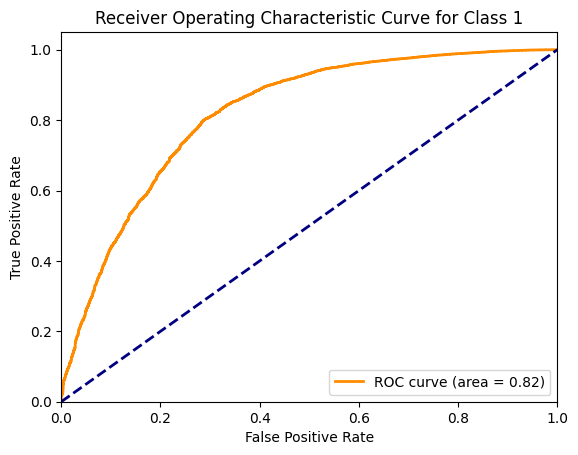

Val Loss: 0.5500, Val Accuracy: 0.7778, Val Precision: 0.9851, Val Recall: 0.8421


In [203]:
torch.cuda.empty_cache()
target_scores, non_target_scores = [], []
loss, acc, target_scores, non_target_scores = evaluate_model(
    model,
    test_loader_21,
    feature_extractor=feature_extractor,
    criterion=criterion,
    device=device,
    max_length=188
)